In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

idx = pd.IndexSlice

with pd.HDFStore('data/data.h5') as store:
    lr_predictions = store['lr/predictions']
    lasso_predictions = store['lasso/predictions']
    lasso_scores = store['lasso/scores']
    ridge_predictions = store['ridge/predictions']
    ridge_scores = store['ridge/scores']

DATA_STORE = Path('data', 'assets.h5')

In [12]:
def get_trade_prices(tickers, start, stop):
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'adj_open']
    return (prices.unstack('symbol').sort_index().shift(-1).tz_localize('UTC'))

def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

def get_factor(predictions):
    return (predictions.unstack('symbol').dropna(how='all').stack().tz_localize('UTC', level='date')
            .sort_index())

In [18]:
# Linear Regression
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head().append(lr_factor.tail())

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.001918
                           AAPL     -0.001493
                           ABBV      0.001507
                           AGN       0.001644
                           AIG      -0.000317
2017-11-29 00:00:00+00:00  WBA      -0.001076
                           WDC      -0.000948
                           WFC       0.000834
                           WMT      -0.001412
                           XOM      -0.001263
dtype: float64

In [29]:
tickers = lr_factor.index.get_level_values('symbol').unique()
len(tickers)

trade_prices = get_trade_prices(tickers, 2014, 2017)
trade_prices.info()

KeyError: 'Level symbol not found'

In [31]:
trade_prices.tail()

symbol,AAL,AAPL,ABBV,AGN,AIG,AMGN,AMZN,APA,APC,AXP,...,ADP,VRTX,CCI,AAOI,COL,EL,SBAC,EFX,PCG,GWW
date,,,,,,,,,,,,,,,,,,,,,
2017-12-22 00:00:00+00:00,52.35,170.80,98.15,164.53,59.22,176.18,1168.36,43.13,53.20,98.80,...,117.15,149.50,108.55,39.51,135.20,127.78,159.52,119.75,44.77,234.00
2017-12-26 00:00:00+00:00,52.80,170.10,97.73,164.42,59.29,176.44,1179.91,43.30,54.10,98.90,...,117.78,151.13,109.12,38.65,135.10,128.64,160.71,119.02,44.47,236.01
2017-12-27 00:00:00+00:00,52.45,171.00,98.19,164.94,59.70,176.77,1189.00,42.83,53.78,99.64,...,117.59,152.19,109.64,38.76,135.19,127.62,161.08,119.82,44.86,237.43
2017-12-28 00:00:00+00:00,52.42,170.52,98.14,164.61,59.97,175.25,1182.35,43.02,53.98,100.00,...,116.64,150.45,110.00,38.60,135.50,127.80,163.56,120.05,44.85,237.96
2017-12-29 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# factor : multi-index Series/DataFrame
# prices : chk above
# periods : calculating forward returns
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor, prices=trade_prices,
                                                      quantiles=4, periods=(1, 5, 10, 21))
lr_factor_data.head().append(lr_factor_data.tail())

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        5D       10D       21D  \
date                      asset                                           
2014-12-09 00:00:00+00:00 AAL    0.000000 -0.030924  0.017269  0.025301   
                          AAPL  -0.018792 -0.063718 -0.015995 -0.015820   
                          ABBV  -0.042627 -0.056740 -0.067540 -0.044643   
                          AGN   -0.009914 -0.017159 -0.022802  0.049684   
                          AIG   -0.007596 -0.038162  0.024778 -0.038886   
2017-11-29 00:00:00+00:00 WBA    0.000417 -0.014180 -0.006395  0.009732   
                          WDC   -0.032349 -0.047852  0.023804 -0.015991   
                          WFC   -0.008066  0.024899  0.042960  0.077678   
                          WMT   -0.004893 -0.010501  0.003313  0.013355   
                          XOM    0.012007 -0.000606  0.007156  0.018799   

                                   factor  factor_quantile  
date                      asset                             
2014-12-09 00:00:00+00:00 AAL    0.001918                4  
                          AAPL  -0.001493                2  
                          ABBV   0.001507                4  
                          AGN    0.001644                4  
                          AIG   -0.000317                2  
2017-11-29 00:00:00+00:00 WBA   -0.001076                2  
                          WDC   -0.000948                2  
                          WFC    0.000834                4  
                          WMT   -0.001412                1  
                          XOM   -0.001263                2

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.047206,0.009519,-0.002842,0.003989,18727,25.288303
2,-0.014713,0.011928,-0.000548,0.003357,18623,25.147865
3,-0.012868,0.014126,0.000810,0.003419,17977,24.275529
4,-0.010734,0.038348,0.003027,0.004190,18727,25.288303


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.029,0.017,0.006,0.003
beta,-0.007,-0.077,-0.058,0.010
Mean Period Wise Return Top Quantile (bps),1.661,0.608,0.078,0.176
Mean Period Wise Return Bottom Quantile (bps),-1.946,-0.448,-0.209,-0.508
Mean Period Wise Spread (bps),3.607,1.072,0.297,0.676


Information Analysis


,1D,5D,10D,21D
IC Mean,0.019,0.012,0.010,0.011
IC Std.,0.181,0.168,0.166,0.154
Risk-Adjusted IC,0.104,0.071,0.062,0.071
t-stat(IC),2.861,1.937,1.697,1.956
p-value(IC),0.004,0.053,0.090,0.051
IC Skew,0.012,-0.008,0.001,-0.039
IC Kurtosis,-0.129,-0.170,-0.149,-0.262


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.270,0.482,0.583,0.684
Quantile 2 Mean Turnover,0.466,0.651,0.712,0.743
Quantile 3 Mean Turnover,0.478,0.665,0.725,0.752
Quantile 4 Mean Turnover,0.273,0.486,0.591,0.694


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.822,0.55,0.396,0.242


<Figure size 432x288 with 0 Axes>

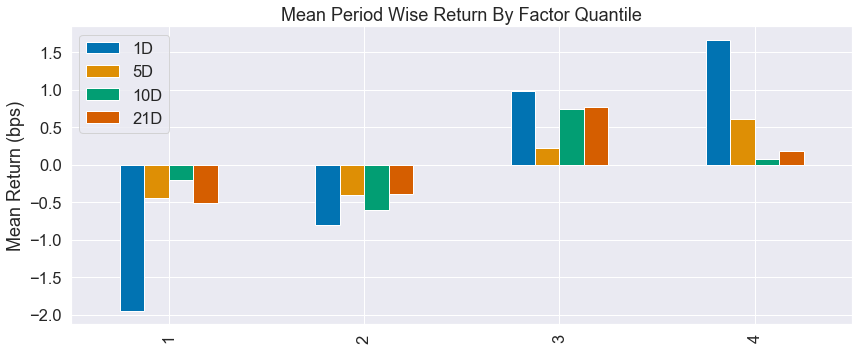

In [34]:
create_summary_tear_sheet(lr_factor_data)

In [35]:
# Ridge Regression(L2 regulation)
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.002029
                           AAPL     -0.001251
                           ABBV      0.001259
                           AGN       0.001453
                           AIG      -0.000452
dtype: float64

In [36]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor, prices=trade_prices,
                                                         quantiles=4, periods=(1, 5, 10, 21))
ridge_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74054 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC', freq='C'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC', freq='C'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74054 non-null  float64
 1   5D               74054 non-null  float64
 2   10D              74054 non-null  float64
 3   21D              74054 non-null  float64
 4   factor           74054 non-null  float64
 5   factor_quantile  74054 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.036355,0.009933,-0.003066,0.003578,18727,25.288303
2,-0.012024,0.012323,-0.000914,0.003077,18623,25.147865
3,-0.010261,0.014010,0.000372,0.003177,17977,24.275529
4,-0.008253,0.038408,0.002445,0.003962,18727,25.288303


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.029,0.019,0.010,0.006
beta,-0.003,-0.078,-0.059,0.012
Mean Period Wise Return Top Quantile (bps),1.403,0.452,0.039,0.153
Mean Period Wise Return Bottom Quantile (bps),-2.008,-1.035,-0.653,-0.717
Mean Period Wise Spread (bps),3.411,1.503,0.701,0.863


Information Analysis


,1D,5D,10D,21D
IC Mean,0.019,0.013,0.011,0.011
IC Std.,0.181,0.169,0.168,0.154
Risk-Adjusted IC,0.105,0.076,0.068,0.070
t-stat(IC),2.878,2.082,1.860,1.920
p-value(IC),0.004,0.038,0.063,0.055
IC Skew,0.011,-0.006,-0.009,-0.044
IC Kurtosis,-0.146,-0.179,-0.141,-0.240


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.264,0.473,0.575,0.678
Quantile 2 Mean Turnover,0.456,0.647,0.709,0.744
Quantile 3 Mean Turnover,0.469,0.660,0.724,0.753
Quantile 4 Mean Turnover,0.271,0.479,0.589,0.693


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.825,0.568,0.41,0.252


<Figure size 432x288 with 0 Axes>

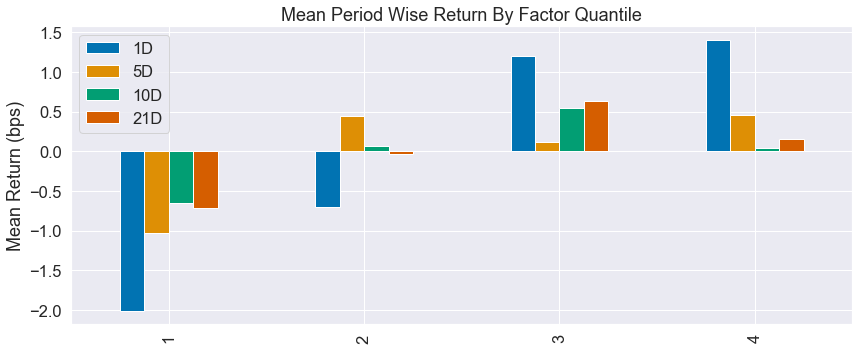

In [37]:
create_summary_tear_sheet(ridge_factor_data)

In [38]:
# Lasso Regression
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.tail()

date                       symbol
2017-11-29 00:00:00+00:00  WBA      -0.001871
                           WDC      -0.001733
                           WFC       0.000081
                           WMT      -0.001943
                           XOM      -0.001956
dtype: float64

In [39]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor, prices=trade_prices,
                                                      quantiles=4, periods=(1, 5, 10, 21))
lasso_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74054 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC', freq='C'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC', freq='C'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74054 non-null  float64
 1   5D               74054 non-null  float64
 2   10D              74054 non-null  float64
 3   21D              74054 non-null  float64
 4   factor           74054 non-null  float64
 5   factor_quantile  74054 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.044674,0.010108,-0.003137,0.003768,18727,25.288303
2,-0.013557,0.012470,-0.000917,0.003255,18623,25.147865
3,-0.011750,0.014502,0.000407,0.003382,17977,24.275529
4,-0.009453,0.038126,0.002556,0.004228,18727,25.288303


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.030,0.018,0.007,0.005
beta,-0.006,-0.077,-0.056,0.011
Mean Period Wise Return Top Quantile (bps),1.542,0.612,0.068,0.205
Mean Period Wise Return Bottom Quantile (bps),-2.278,-0.940,-0.569,-0.739
Mean Period Wise Spread (bps),3.820,1.568,0.646,0.934


Information Analysis


,1D,5D,10D,21D
IC Mean,0.019,0.012,0.011,0.011
IC Std.,0.182,0.169,0.168,0.154
Risk-Adjusted IC,0.107,0.074,0.063,0.073
t-stat(IC),2.920,2.027,1.718,2.003
p-value(IC),0.004,0.043,0.086,0.046
IC Skew,0.011,0.000,-0.004,-0.040
IC Kurtosis,-0.147,-0.181,-0.149,-0.267


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.268,0.480,0.579,0.683
Quantile 2 Mean Turnover,0.462,0.652,0.711,0.744
Quantile 3 Mean Turnover,0.475,0.661,0.724,0.752
Quantile 4 Mean Turnover,0.272,0.485,0.592,0.696


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.823,0.555,0.4,0.242


<Figure size 432x288 with 0 Axes>

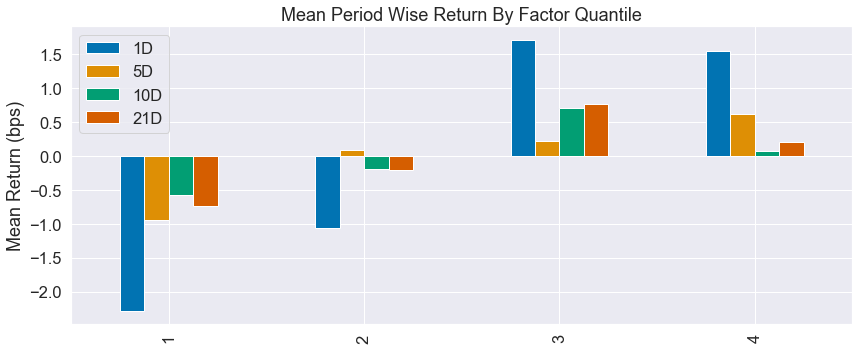

In [40]:
create_summary_tear_sheet(lasso_factor_data)